In [4]:
import os
import sys
import pandas as pd
import numpy as np
from obspy import read
from glob import glob
import matplotlib.pyplot as plt
sys.path.append('..')
import core.feature_extraction as fe
from importlib import reload

%matplotlib widget

In [30]:
# Get test_dataset_1 data
wf_data = os.path.join('..','data','test_dataset_1','UW','GNW','UW.GNW..EN?.2017*.mseed')

ml_pred = os.path.join('..','data','test_dataset_1','UW','GNW','UW.GNW.EW.EN?.2017.131.mseed')
st = read(ml_pred,fmt='MSEED')
for _f in glob(wf_data):
    st += read(_f, fmt='MSEED')
st.merge(method=1).trim(endtime=st[0].stats.starttime + 4*3600)

6 Trace(s) in Stream:
UW.GNW..ENE   | 2017-05-11T00:00:00.005000Z - 2017-05-11T04:00:00.005000Z | 100.0 Hz, 1440001 samples
UW.GNW..ENN   | 2017-05-11T00:00:00.005000Z - 2017-05-11T04:00:00.005000Z | 100.0 Hz, 1440001 samples
UW.GNW..ENZ   | 2017-05-11T00:00:00.005000Z - 2017-05-11T04:00:00.005000Z | 100.0 Hz, 1440001 samples
UW.GNW.EW.END | 2017-05-11T00:00:05.005000Z - 2017-05-11T04:00:00.005000Z | 100.0 Hz, 1439501 samples
UW.GNW.EW.ENP | 2017-05-11T00:00:05.005000Z - 2017-05-11T04:00:00.005000Z | 100.0 Hz, 1439501 samples
UW.GNW.EW.ENS | 2017-05-11T00:00:05.005000Z - 2017-05-11T04:00:00.005000Z | 100.0 Hz, 1439501 samples

In [16]:
reload(fe)

<module 'core.feature_extraction' from '/Users/nates/Code/Sci-Prod-ML/ml_prediction/notebooks/../core/feature_extraction.py'>

In [31]:
# Try out the core feature_extraction process
tr = st.select(channel='??P')[0]

df_pick = fe.process_est_prediction_stats(tr)

# df_pick = fe.process_predictions(
#     tr, thr_on=0.1, thr_off=0.1, fit_pad_sec=0.0, fit_thr_coef=0.125, ndata_bounds=[10,9e99],quantiles=[0.16,0.25,0.5,0.75,0.84]
# )
# triggers = fe.trigger_onset(tr.data,0.1,0.1)
# display(triggers)

In [32]:
display(df_pick.T)

,0,1,2,3,4,5
et_on,1.494462e+09,1.494463e+09,1.494467e+09,1.494468e+09,1.494470e+09,1.494471e+09
et_off,1.494462e+09,1.494463e+09,1.494467e+09,1.494468e+09,1.494470e+09,1.494471e+09
et_max,1.494462e+09,1.494463e+09,1.494467e+09,1.494468e+09,1.494470e+09,1.494471e+09
p_max,5.279133e-01,6.716610e-01,6.745948e-01,6.820437e-01,7.270271e-01,6.169132e-01
et_mean,1.494462e+09,1.494463e+09,1.494467e+09,1.494468e+09,1.494470e+09,1.494471e+09
p_mean,5.193253e-01,6.645343e-01,6.275413e-01,6.496027e-01,6.907741e-01,6.118714e-01
dt_std,1.306450e-01,1.230433e-01,1.321277e-01,1.232551e-01,1.175591e-01,1.393575e-01
ndata,6.200000e+01,6.200000e+01,6.500000e+01,6.200000e+01,6.000000e+01,6.700000e+01
et_med,1.494462e+09,1.494463e+09,1.494467e+09,1.494468e+09,1.494470e+09,1.494471e+09
p_med,5.140778e-01,6.645343e-01,6.406776e-01,6.488678e-01,7.270271e-01,6.141684e-01


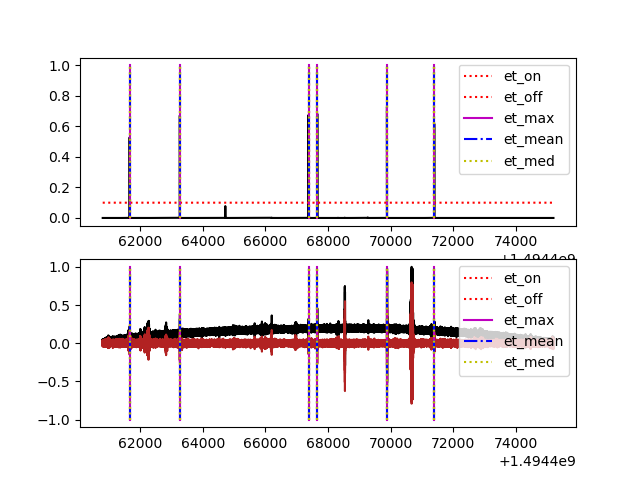

In [39]:
ml_tr = st.select(channel="??P")[0]
x = ml_tr.times(type="timestamp")
y = ml_tr.data

fig = plt.figure()
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2, sharex=ax1)

ax1.plot(x, y, "k-")
ax1.plot(x, [0.1] * len(x), "r:")
ax2.plot(
    st.select(channel="??Z")[0].times(type="timestamp"),
    st.select(channel="??Z")[0]
    .copy()
    .detrend()
    .normalize()
    .data,
    "k-",
)
ax2.plot(
    st.select(channel="??Z")[0].times(type="timestamp"),
    st.select(channel="??Z")[0]
    .copy()
    .detrend()
    .normalize()
    .filter("bandpass", freqmin=1, freqmax=45)
    .data,
    "-",
    color='firebrick'
)


et_bundle = [
    ("et_on", "r:"),
    ("et_off", "r:"),
    ("et_max", "m-"),
    ("et_mean", "b-."),
    ("et_med", "y:"),
]

for _I in range(len(df_pick)):
    _S = df_pick.iloc[_I, :]
    for ax, yrng in [[ax1, [0, 1]], [ax2, [-1, 1]]]:
        for _f, _c in et_bundle:
            ax.plot([_S[_f]] * 2, yrng, _c, label=_f)
        if _I == 0:
            ax.legend()
        # for _s, _f, _c in [(1, 'dt_std', 'r:'),(1)]

In [6]:
# ml_tr = st.select(channel="??P")[0]
# x = ml_tr.times(type="timestamp")
# y = ml_tr.data
# _S = df_pick.iloc[0,:]
# pp = _S[['p_scale','et_mean','et_std']].values
# display(pp)
# y_hat = fe.scaled_normal_pdf(pp,x)
# display(y_hat)

array([5.27913332e-01, 1.49446166e+09, 1.27499998e-01])

array([0., 0., 0., ..., 0., 0., 0.])

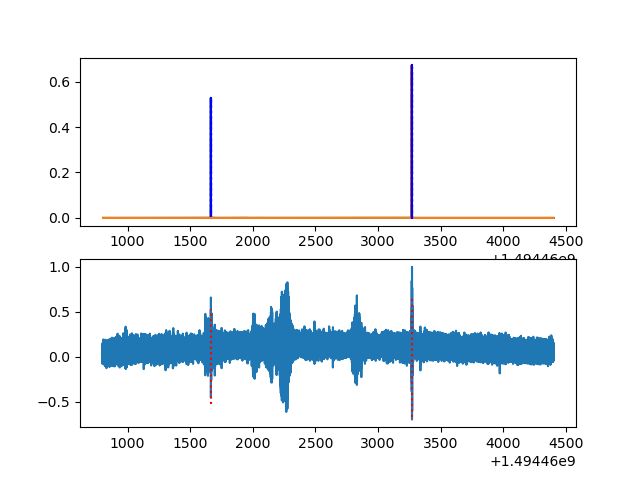

In [12]:
fig = plt.figure()
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2, sharex=ax1)

ax1.plot(x, y, "k-")
# for _i in range(len(df_pick)):
#     _S = df_pick.iloc[_i, :]
#     y_hat = fe.scaled_normal_pdf(_S[["p_scale", "et_mean", "et_std"]].values, x)
#     ax1.plot(x, y_hat)
#     ax1.plot([_S["et_max"]] * 2, [0, _S["p_scale"]], "r:")
#     ax1.plot([_S["q0.16"]] * 2, [0, _S["p_scale"]], "b:")
#     ax1.plot([_S["q0.25"]] * 2, [0, _S["p_scale"]], "b-.")
#     ax1.plot([_S["q0.50"]] * 2, [0, _S["p_scale"]], "b-")
#     ax1.plot([_S["q0.75"]] * 2, [0, _S["p_scale"]], "b-.")

#     ax1.plot([_S["q0.84"]] * 2, [0, _S["p_scale"]], "b:")

# ax2.plot(
#     st.select(channel="??Z")[0].times(type="timestamp"),
#     st.select(channel="??Z")[0]
#     .copy()
#     .detrend()
#     .normalize()
#     .data)
#     # .filter("bandpass", freqmin=1, freqmax=45)
# #     .data,
# # )
# # ax1.set_xlim([pp[1] - 10 * pp[2], pp[1] + 10 * pp[2]])


# for _i in range(len(df_pick)):
#     _S = df_pick.iloc[_i, :]
#     y_hat = fe.scaled_normal_pdf(_S[["p_scale", "et_mean", "et_std"]].values, x)
#     ax2.plot([_S["et_max"]] * 2, np.array([-1, 1]) * _S["p_scale"], "r:")